In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from torchvision import datasets,transforms
import matplotlib.pyplot as plt

seed=42
torch.manual_seed(seed)

### Target
1. Get the setup
2. Set Transforms
3. Set the Data Loader
4. Set the skeleton right
5. Set Training and testing loop
6. Results:



## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [45]:
## Train Phase transformation
train_transforms=transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.1307,),(0.3081,))])

test_transforms=transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.1307,),(0.3081,))])

## Get the Dataset and create train and test split


In [46]:
train_set= datasets.MNIST(root="./data",train=True,download=True,transform=train_transforms)

test_set= datasets.MNIST(root="./data",train=False,download=True,transform=test_transforms)

### Data Loader Arguments & Test and Train Arguments

In [47]:
# CUDA?
is_cuda= torch.cuda.is_available()
print("CUDA Available?",is_cuda)

 #for Reproduciability
torch.manual_seed(seed)


if is_cuda:
  torch.cuda.manual_seed(seed)

# Data Loader Arguments - something you will fetch these from Command Prompt 
dataloader_args=dict(shuffle=True,batch_size=128,num_workers=4,pin_memory=True) if is_cuda else dict(shuffle=True,batch_size=64)

# train loader 
train_loader=torch.utils.data.DataLoader(train_set,**dataloader_args)
test_loader= torch.utils.data.DataLoader(test_set,**dataloader_args)

CUDA Available? True


In [48]:
### Data Statistics
train_data=train_set.transform(train_set.data.cpu().numpy())
print("-Numpy Shape:",train_data.numpy().shape)
print("-Tensor Shape ",train_data.shape)
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

-Numpy Shape: (28, 60000, 28)
-Tensor Shape  torch.Size([28, 60000, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


One batch: torch.Size([128, 1, 28, 28])
Targets of one batch: torch.Size([128])


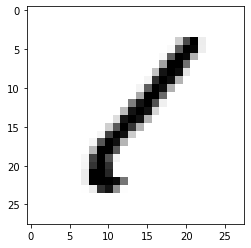

In [49]:
images,labels= next(iter(train_loader))
print("One batch:",images.shape)
print("Targets of one batch:",labels.shape)

plt.imshow(images[0].numpy().squeeze(),cmap="gray_r");

### Illustration of transforms

In [50]:
original_img= images[0]

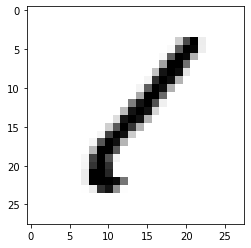

In [51]:
plt.imshow(original_img.squeeze(),cmap="gray_r");

In [52]:
## Create a function to plot the transformed image

def plot(imgs, with_orig=True,row_title=None,**imshow_kwargs):
  if not isinstance(imgs[0],list):
    # make a 2d grid even if there is just 1 row
    imgs=[imgs]
  
  num_rows=len(imgs)
  num_cols= len(imgs[0])+with_orig
  
  fig,axes=plt.subplots(nrows=num_rows,ncols=num_cols,figsize=(12,12),squeeze=False)
  for row_idx,row in enumerate(imgs):    
    row= [original_img]+row if with_orig else row

    for col_idx,img in enumerate(row):     
      ax=axes[row_idx,col_idx]
      ax.imshow(img.squeeze(),** imshow_kwargs)
      ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

  if with_orig:
      axes[0, 0].set(title='Original image')
      axes[0, 0].title.set_size(10)
  if row_title is not None:
      for row_idx in range(num_cols):
          axes[0,row_idx].set(ylabel=row_title[row_idx])

  plt.tight_layout()




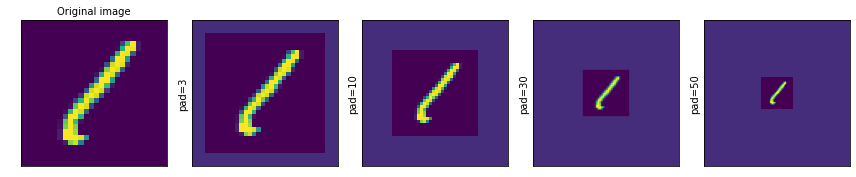

In [53]:
## Pad
padded_imgs= [transforms.Pad(padding=padding)(original_img) for padding in [3,10,30,50]]
plot(padded_imgs,row_title=[" ","pad=3","pad=10","pad=30","pad=50"])

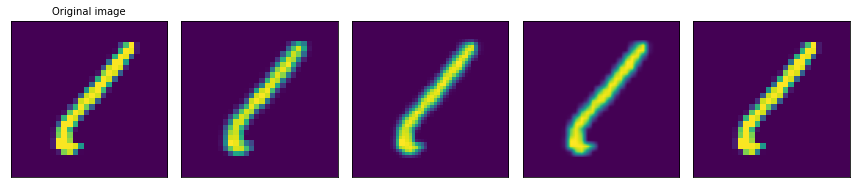

In [54]:
## Resize
resized_img= [transforms.Resize(size=size)(original_img) for size in (30,50,100,original_img.size()[-1])]
plot(resized_img)

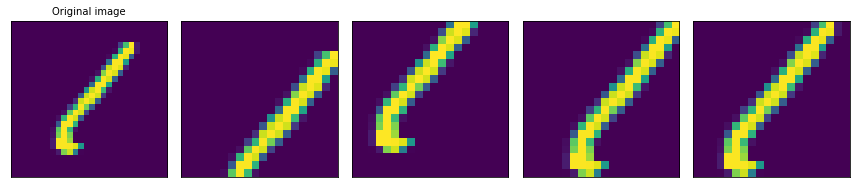

In [55]:
# RandomCrop
random_crop= transforms.RandomCrop(size=(20,20))
crops=[random_crop(original_img) for _ in range(4)]
plot(crops)

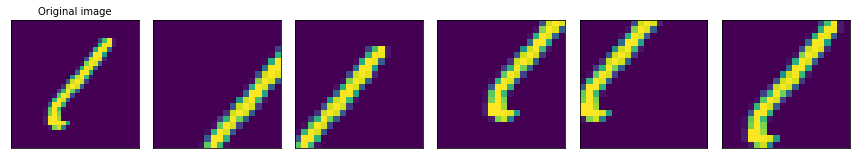

In [56]:
## FiveCrop
(top_left, top_right, bottom_left, bottom_right, center) = transforms.FiveCrop(size=(20, 20))(original_img)
plot([top_left, top_right, bottom_left, bottom_right, center])

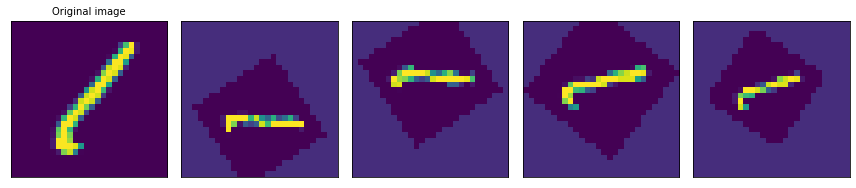

In [57]:
affine_transfomer = transforms.RandomAffine(degrees=(30, 60), translate=(0.1, 0.3), scale=(0.5, 0.75))
affine_imgs = [affine_transfomer(original_img) for _ in range(4)]
plot(affine_imgs)

## Random Transformations : RandomPerspective
 means that the same transfomer instance will produce different result each time it transforms a given image.


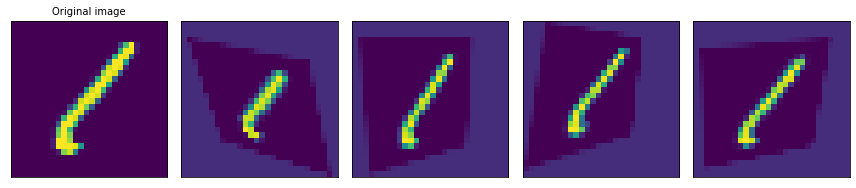

In [58]:
perspective_transformer = transforms.RandomPerspective(distortion_scale=0.6, p=1.0)
perspective_imgs = [perspective_transformer(original_img) for _ in range(4)]
plot(perspective_imgs)

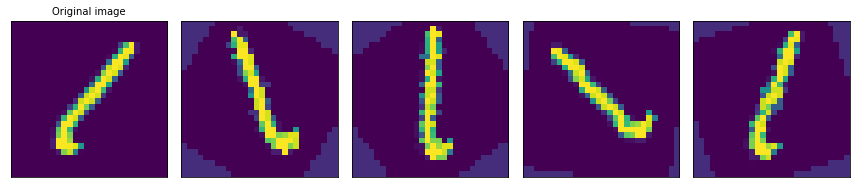

In [59]:
# RandomRotation
rotater = transforms.RandomRotation(degrees=(0, 90))
rotated_imgs = [rotater(original_img) for _ in range(4)]
plot(rotated_imgs)

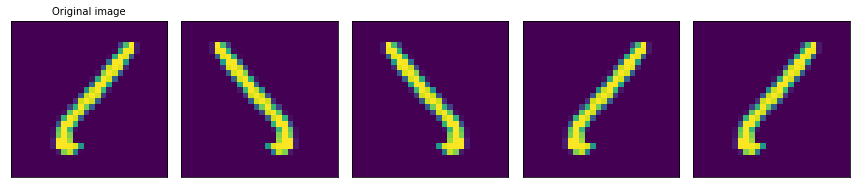

In [60]:
# RandomHorizontalFlip
# Some transforms are randomly-applied given a probability p. That is, the transformed image may actually be the same as the original one, 
# even when called with the same transformer instance!
hflipper = transforms.RandomHorizontalFlip(p=0.5)
transformed_imgs = [hflipper(original_img) for _ in range(4)]
plot(transformed_imgs)

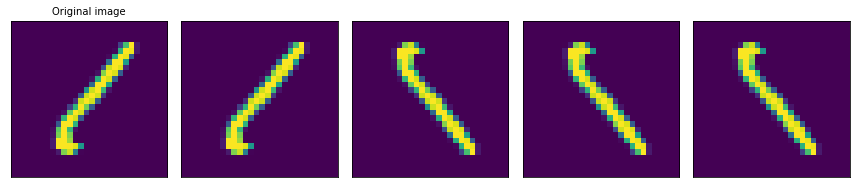

In [61]:
vflipper = transforms.RandomVerticalFlip(p=0.5)
transformed_imgs = [vflipper(original_img) for _ in range(4)]
plot(transformed_imgs)

### Lets get the Data again with some transforms discussed above. We will use this data for training
The PyTorch torchvision library provides us with an MNIST dataset, which downloads the data and provides it in a readily-usable format. Let's use the dataset MNIST function to pull the dataset to our local machine, and then wrap it around a DataLoader. We will use torchvision transformations to convert the data into PyTorch tensors and do data normalization. The following code takes care of downloading, wrapping around the DataLoader and normalizing the data:

**Steps**
1. Initialize transformation
2. Load the data from torchvision dataset
3. Create a dataloader using the data from above step


In [63]:
train_transforms=transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,)),
                                     transforms.RandomVerticalFlip(p=0.5),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.RandomAffine(degrees=(30, 60), translate=(0.1, 0.3), scale=(0.5, 0.75)),
                                     transforms.FiveCrop(size=(20, 20)),
                                     transforms.Resize(size=20)
                                     ])

test_transforms=transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,)),
                                     transforms.RandomVerticalFlip(p=0.5),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.RandomAffine(degrees=(30, 60), translate=(0.1, 0.3), scale=(0.5, 0.75)),
                                     transforms.FiveCrop(size=(20, 20)),
                                     transforms.Resize(size=20)
                                     ])                                    

In [64]:
# get train_set
train_set= datasets.MNIST(root="./data",train=True,download=True,transform=train_transforms)
test_set= datasets.MNIST(root="./data",train=False,download=True,transform=test_transforms)

In [65]:
# Create dataLoaders
train_loaders=torch.utils.data.DataLoader(train_set,**dataloader_args)
test_loaders=torch.utils.data.DataLoader(test_set,**dataloader_args)

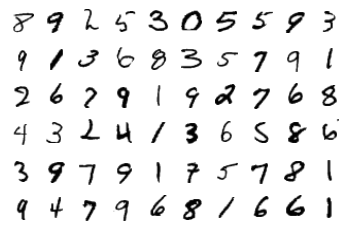

In [66]:
# lets visualize some more images
images,labels= next(iter(train_loader))
num_of_images=60
for index in range(1,num_of_images+1):
  plt.subplot(6, 10, index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')


- Target: 

      Add RandomVerticalFlip(p=0.5),RandomHorizontalFlip(p=0.5),RandomAffine  (degrees=(30, 60), translate=(0.1, 0.3), scale=(0.5, 0.75)),FiveCrop(size=(20, 20)),Resize. 
- Results:
        Parameters: 9,774
        Best Train Accuracy: 98.92
        Best Test Accuracy: 99.518(20th Epoch)
- Analysis:
        The model is under-fitting now. This is fine, as we know we have made our train data harder. 
        The test accuracy is also up, which means our test data had few images which had transformation difference w.r.t. train dataset


In [67]:
dropout_value=0.1
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    # Input Block
    self.convblock1= nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=10,kernel_size=(7,7),padding=0,bias=False),        
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Dropout(dropout_value)
        ) # output_size=26 | 3

    # CONVOLUTION BLOCK 1
    self.convblock2= nn.Sequential(
        nn.Conv2d(in_channels=10,out_channels=10,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Dropout(dropout_value)
    ) # output_size=24 | 5

    self.convblock3= nn.Sequential(
        nn.Conv2d(in_channels=10,out_channels=10,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Dropout(dropout_value)
    ) # output_size=22 | 7

    # TRANSITION BLOCK 1
    self.pool1= nn.MaxPool2d(2,2) # output_size=11 | 14
    self.convblock4= nn.Sequential(
        nn.Conv2d(in_channels=10,out_channels=32,kernel_size=(1,1),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(dropout_value)
    ) # output_size= 11 | 16

    # CONVOLUTION BLOCK 2
    self.convblock5= nn.Sequential(
        nn.Conv2d(in_channels=32,out_channels=20,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(20),
        nn.Dropout(dropout_value)
    ) # output_size=9 | 18
    self.convblock6= nn.Sequential(
        nn.Conv2d(in_channels=20,out_channels=10,kernel_size=(1,1),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Dropout(dropout_value)
    ) # output_size=7 |20

    # OUTPUT BLOCK 
    self.convblock7 = nn.Sequential(
        nn.Conv2d(in_channels=10,out_channels=10,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Dropout(dropout_value) 
    ) # output_size= 7 | 20
    # OUTPUT BLOCK
    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=5)
    ) # output_size = 1

    self.convblock8 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        # nn.BatchNorm2d(10),
        # nn.ReLU(),
        # nn.Dropout(dropout_value)
               ) 


        
  def forward(self,x):
    x= self.convblock1(x)
    x= self.convblock2(x)
    x= self.convblock3(x)
    x= self.pool1(x)
    x= self.convblock4(x)
    x= self.convblock5(x)
    x= self.convblock6(x)
    x= self.convblock7(x)
    x = self.gap(x)
    x= self.convblock8(x)
    x= x.view(-1,10)
    return F.log_softmax(x,dim=-1)



       

## Model Params

In [68]:
# ! pip install torchsummary

In [69]:
from torchsummary import summary
device= torch.device("cuda" if is_cuda else "cpu")
model= Net().to(device)
summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 22, 22]             490
              ReLU-2           [-1, 10, 22, 22]               0
       BatchNorm2d-3           [-1, 10, 22, 22]              20
           Dropout-4           [-1, 10, 22, 22]               0
            Conv2d-5           [-1, 10, 20, 20]             900
              ReLU-6           [-1, 10, 20, 20]               0
       BatchNorm2d-7           [-1, 10, 20, 20]              20
           Dropout-8           [-1, 10, 20, 20]               0
            Conv2d-9           [-1, 10, 18, 18]             900
             ReLU-10           [-1, 10, 18, 18]               0
      BatchNorm2d-11           [-1, 10, 18, 18]              20
          Dropout-12           [-1, 10, 18, 18]               0
        MaxPool2d-13             [-1, 10, 9, 9]               0
           Conv2d-14             [-1, 3

## Training and Testing
Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [70]:
# training block
from tqdm import tqdm

def train(data_loader,model,optimizer):
    model.train() # set the mode(train/test)
    progress_bar= tqdm(data_loader)
    running_loss=0.0
    running_correct= 0

    # iterate over data- Access batch_id and images and labels
    for batch_idx,(images,target) in enumerate(progress_bar):
      # get samples
      images,target= images.to(device),target.to(device)      
      
      # compute prediction error
      y_pred= model(images)
      loss= F.nll_loss(y_pred,target)
      running_loss+=loss.item() # accumulating loss across every batch
      preds= y_pred.argmax(dim=1,keepdims=True) # get the index of the max log-probability
      running_correct+=preds.eq(target.view_as(preds)).cpu().sum().item()

      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.
      # Backpropogation  
      optimizer.zero_grad()          
      loss.backward()
      optimizer.step()     

    # calculate Loss and accuracy accross every epoch
    loss= running_loss/len(data_loader.dataset)
    accuracy=100*(running_correct/len(data_loader.dataset))  

    print(f"Training Loss {loss} Training Accuracy {accuracy:.2f}")    
    return loss, accuracy


In [71]:
def test(data_loader,model,optimizer):
  model.eval()
  progress_bar= tqdm(data_loader)
  running_loss=0.0
  running_correct= 0

  with torch.no_grad():
    for batch_idx,(images,target) in enumerate(progress_bar):
      # get samples
      images,target= images.to(device),target.to(device)

      # prediction
      y_preds= model(images)
      loss=F.nll_loss(y_preds,target)
      running_loss+=loss.item()
      preds= y_preds.argmax(dim=1,keepdims=True) # get the index of the max log-probability
      running_correct+=preds.eq(target.view_as(preds)).cpu().sum().item()

    loss= running_loss/len(data_loader.dataset)
    accuracy=100*(running_correct/len(data_loader.dataset)) 
    print(f"Validation Loss {loss} Validation Accuracy {accuracy:.2f}")
    return loss,accuracy



In [72]:
# model with first filter as 5,5
model=Net().to(device)
optimizer= optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
EPOCHS=20
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,EPOCHS+1):
  print("EPOCH:",epoch)
  epoch_loss, epoch_accuracy= train(train_loader,model,optimizer)
  val_epoch_loss , val_epoch_accuracy = test(test_loader,model,optimizer)
  train_losses.append(epoch_loss)
  train_accuracy.append(epoch_accuracy)
  val_losses.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)

EPOCH: 1


100%|██████████| 469/469 [00:12<00:00, 38.31it/s]


Training Loss 0.004284193519254525 Training Accuracy 85.95


100%|██████████| 79/79 [00:02<00:00, 38.67it/s]


Validation Loss 0.001285888433456421 Validation Accuracy 95.27
EPOCH: 2


100%|██████████| 469/469 [00:12<00:00, 37.74it/s]


Training Loss 0.0008819535673285524 Training Accuracy 96.80


100%|██████████| 79/79 [00:02<00:00, 37.03it/s]


Validation Loss 0.0006089094890281558 Validation Accuracy 97.83
EPOCH: 3


100%|██████████| 469/469 [00:12<00:00, 38.07it/s]


Training Loss 0.0006915342740093668 Training Accuracy 97.41


100%|██████████| 79/79 [00:02<00:00, 38.16it/s]


Validation Loss 0.0004800444577820599 Validation Accuracy 98.31
EPOCH: 4


100%|██████████| 469/469 [00:12<00:00, 38.44it/s]


Training Loss 0.0005745544083106021 Training Accuracy 97.84


100%|██████████| 79/79 [00:02<00:00, 37.36it/s]


Validation Loss 0.0006724359642248601 Validation Accuracy 97.21
EPOCH: 5


100%|██████████| 469/469 [00:12<00:00, 37.51it/s]


Training Loss 0.0005087627521095176 Training Accuracy 98.07


100%|██████████| 79/79 [00:02<00:00, 37.52it/s]


Validation Loss 0.00040358002968132495 Validation Accuracy 98.44
EPOCH: 6


100%|██████████| 469/469 [00:13<00:00, 34.98it/s]


Training Loss 0.00046144751996422806 Training Accuracy 98.24


100%|██████████| 79/79 [00:02<00:00, 38.18it/s]


Validation Loss 0.00046419649664312604 Validation Accuracy 98.20
EPOCH: 7


100%|██████████| 469/469 [00:12<00:00, 38.21it/s]


Training Loss 0.000434216943445305 Training Accuracy 98.34


100%|██████████| 79/79 [00:02<00:00, 38.54it/s]


Validation Loss 0.00038561722720041873 Validation Accuracy 98.43
EPOCH: 8


100%|██████████| 469/469 [00:12<00:00, 38.23it/s]


Training Loss 0.00039479208205205697 Training Accuracy 98.46


100%|██████████| 79/79 [00:02<00:00, 39.08it/s]


Validation Loss 0.00027648283645976337 Validation Accuracy 98.93
EPOCH: 9


100%|██████████| 469/469 [00:12<00:00, 38.07it/s]


Training Loss 0.0003835382092744112 Training Accuracy 98.56


100%|██████████| 79/79 [00:02<00:00, 38.13it/s]


Validation Loss 0.00024409539599437266 Validation Accuracy 99.00
EPOCH: 10


100%|██████████| 469/469 [00:12<00:00, 37.71it/s]


Training Loss 0.000357318519280913 Training Accuracy 98.59


100%|██████████| 79/79 [00:02<00:00, 38.03it/s]


Validation Loss 0.00026945573415141554 Validation Accuracy 98.98
EPOCH: 11


100%|██████████| 469/469 [00:12<00:00, 38.09it/s]


Training Loss 0.00035340484206099063 Training Accuracy 98.57


100%|██████████| 79/79 [00:02<00:00, 36.58it/s]


Validation Loss 0.0002336191506474279 Validation Accuracy 99.13
EPOCH: 12


100%|██████████| 469/469 [00:12<00:00, 38.09it/s]


Training Loss 0.00032761030970917393 Training Accuracy 98.69


100%|██████████| 79/79 [00:02<00:00, 39.00it/s]


Validation Loss 0.00023165233657346107 Validation Accuracy 99.09
EPOCH: 13


100%|██████████| 469/469 [00:12<00:00, 38.55it/s]


Training Loss 0.0003232151251519099 Training Accuracy 98.72


100%|██████████| 79/79 [00:02<00:00, 38.73it/s]


Validation Loss 0.00024217055847402662 Validation Accuracy 99.07
EPOCH: 14


100%|██████████| 469/469 [00:12<00:00, 38.13it/s]


Training Loss 0.00030984707043195766 Training Accuracy 98.74


100%|██████████| 79/79 [00:02<00:00, 39.03it/s]


Validation Loss 0.00023963122090790422 Validation Accuracy 99.03
EPOCH: 15


100%|██████████| 469/469 [00:13<00:00, 35.31it/s]


Training Loss 0.0003005886447848752 Training Accuracy 98.80


100%|██████████| 79/79 [00:02<00:00, 38.55it/s]


Validation Loss 0.00021225791893084533 Validation Accuracy 99.07
EPOCH: 16


100%|██████████| 469/469 [00:12<00:00, 38.04it/s]


Training Loss 0.0002906201226947208 Training Accuracy 98.84


100%|██████████| 79/79 [00:02<00:00, 39.20it/s]


Validation Loss 0.00026343049448914824 Validation Accuracy 99.03
EPOCH: 17


100%|██████████| 469/469 [00:12<00:00, 38.71it/s]


Training Loss 0.0002934817371734728 Training Accuracy 98.82


100%|██████████| 79/79 [00:02<00:00, 38.34it/s]


Validation Loss 0.00020961316855391487 Validation Accuracy 99.14
EPOCH: 18


100%|██████████| 469/469 [00:12<00:00, 37.53it/s]


Training Loss 0.00028500363582667585 Training Accuracy 98.87


100%|██████████| 79/79 [00:02<00:00, 38.27it/s]


Validation Loss 0.00018884344939142466 Validation Accuracy 99.24
EPOCH: 19


100%|██████████| 469/469 [00:12<00:00, 38.20it/s]


Training Loss 0.0002741677739929097 Training Accuracy 98.89


100%|██████████| 79/79 [00:02<00:00, 38.75it/s]


Validation Loss 0.00022511586210457608 Validation Accuracy 99.05
EPOCH: 20


100%|██████████| 469/469 [00:12<00:00, 38.48it/s]


Training Loss 0.00027167400201239314 Training Accuracy 98.92


100%|██████████| 79/79 [00:02<00:00, 38.60it/s]

Validation Loss 0.00020696193991461768 Validation Accuracy 99.18


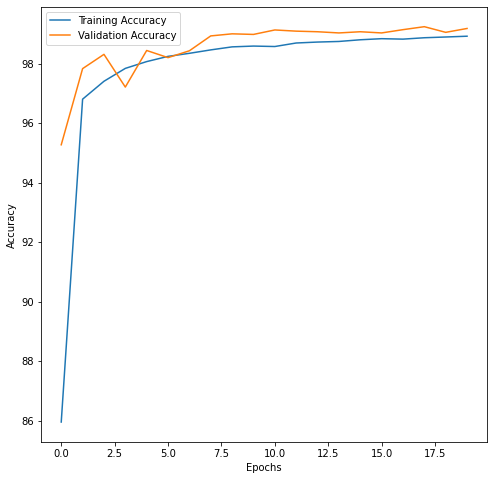

In [73]:

## Plot the logs
%matplotlib inline
import seaborn as sns
plt.figure(figsize=(8,8))
sns.lineplot(y=train_accuracy,x=range(len(train_accuracy)),label="Training Accuracy")
sns.lineplot(y=val_accuracy,x=range(len(val_accuracy)),label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

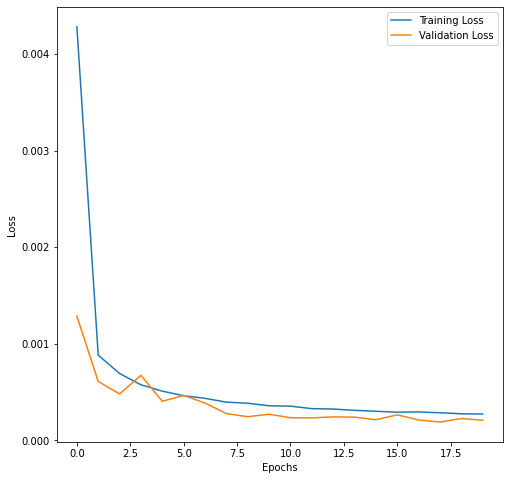

In [74]:
plt.figure(figsize=(8,8))
sns.lineplot(y=train_losses,x=range(len(train_losses)),label="Training Loss")
sns.lineplot(y=val_losses,x=range(len(val_losses)),label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()